In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries
from MaStarChecks.plotting import triang_plot


PROCESSED_PATH = os.path.join("_data", "processed-libraries-v3.0.1")

LABELS = ("MILES", "IndoUS", "MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET"]

In [2]:
spectra, catalogue = load_libraries(labels=LABELS, libraries_path=PROCESSED_PATH, impute_missing=False, use_cache=True, cache_path=CACHE_PATH)

Y = catalogue.filter(items=Y_COLUMNS).dropna(how="any")
M = spectra.loc[Y.index]

Y["TEFF"] = np.log10(Y["TEFF"])

X = M.copy()
e = 0.1 * X

In [3]:
if os.path.isfile(os.path.join(CACHE_PATH, "auto-fitting-chi_rd.p")):
    chi_rd = pickle.load(open(os.path.join(CACHE_PATH, "auto-fitting-chi_rd.p"), "rb"))
else:
    chi_rd = pd.DataFrame(index=X.index, columns=M.index)
    for sed_name in tqdm(X.index, desc="SED fitting MaStar", unit="SED"):
        chi_sq = ((M - X.loc[sed_name].values[None, :]) ** 2 / e[e!=0].loc[sed_name].values[None, :] ** 2).sum(axis="columns")

        chi_rd.loc[sed_name, :] = chi_sq / (X.columns.size - 1 - 3)

    pickle.dump(chi_rd, open(os.path.join(CACHE_PATH, "auto-fitting-chi_rd.p"), "wb"))

chi_rd = chi_rd.astype(np.float)

In [4]:
# fig, ax = plt.subplots(figsize=(14,14))

# ax.set_aspect("equal")
# ax.tick_params(labelsize="small")

# sns.heatmap(chi_rd.mask(chi_rd>2), ax=ax)

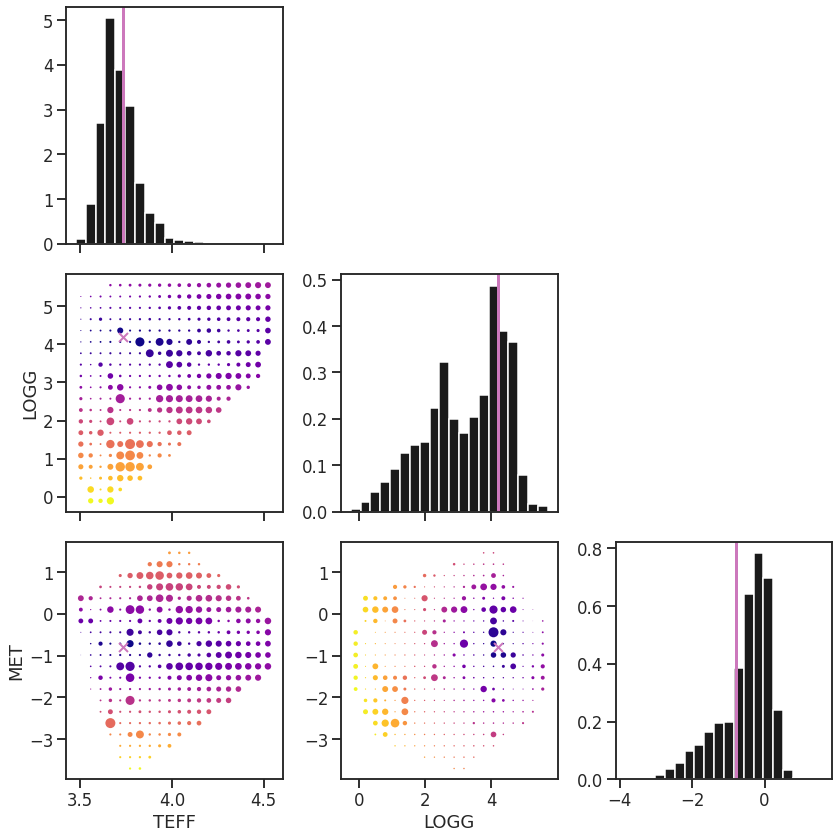

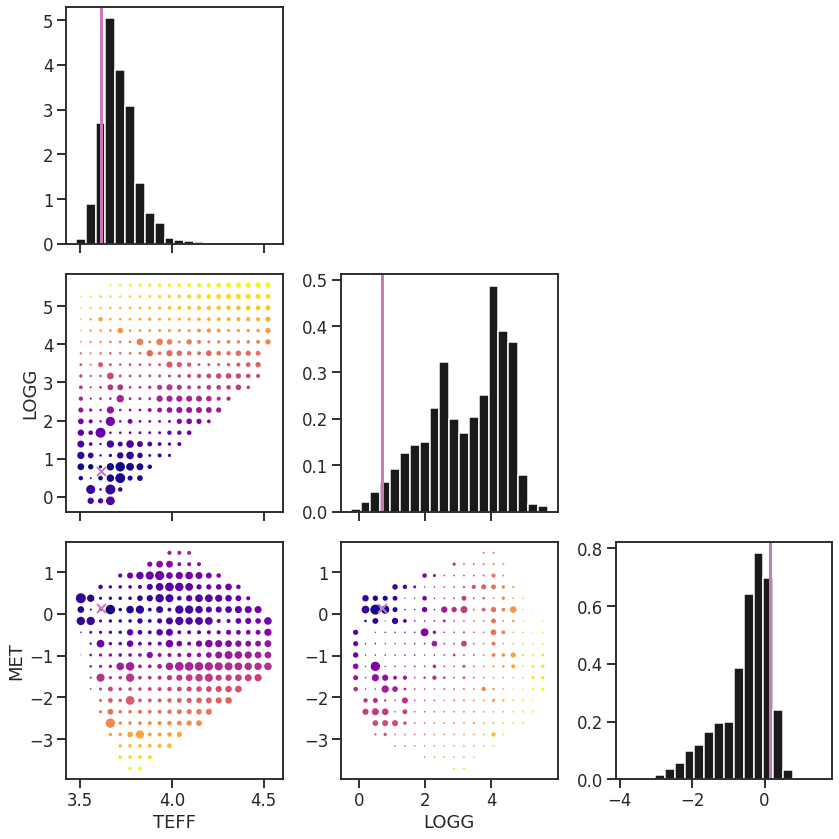

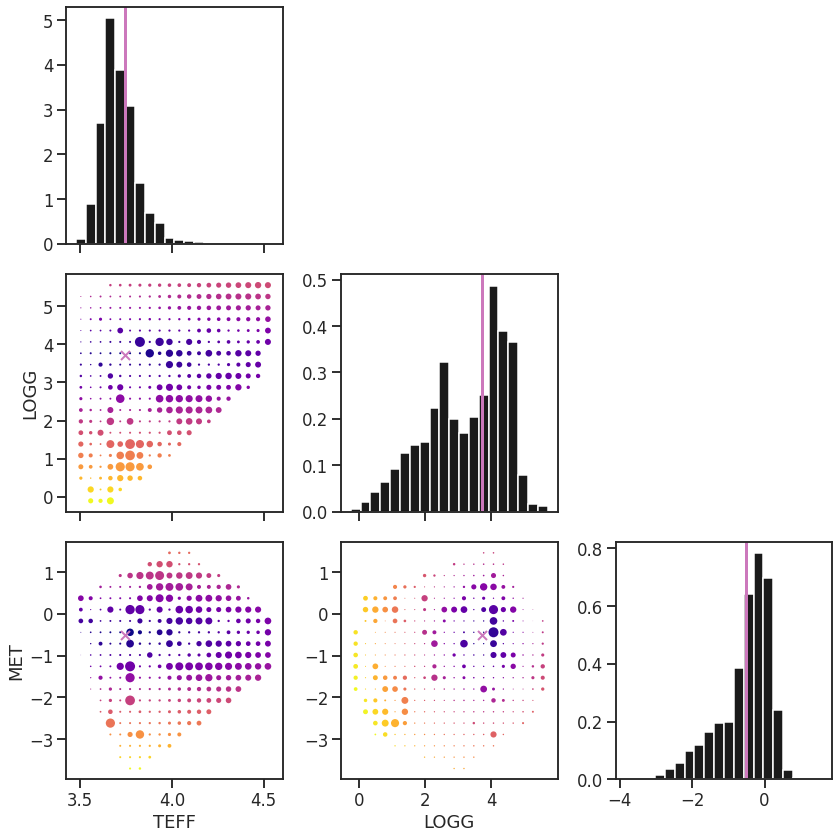

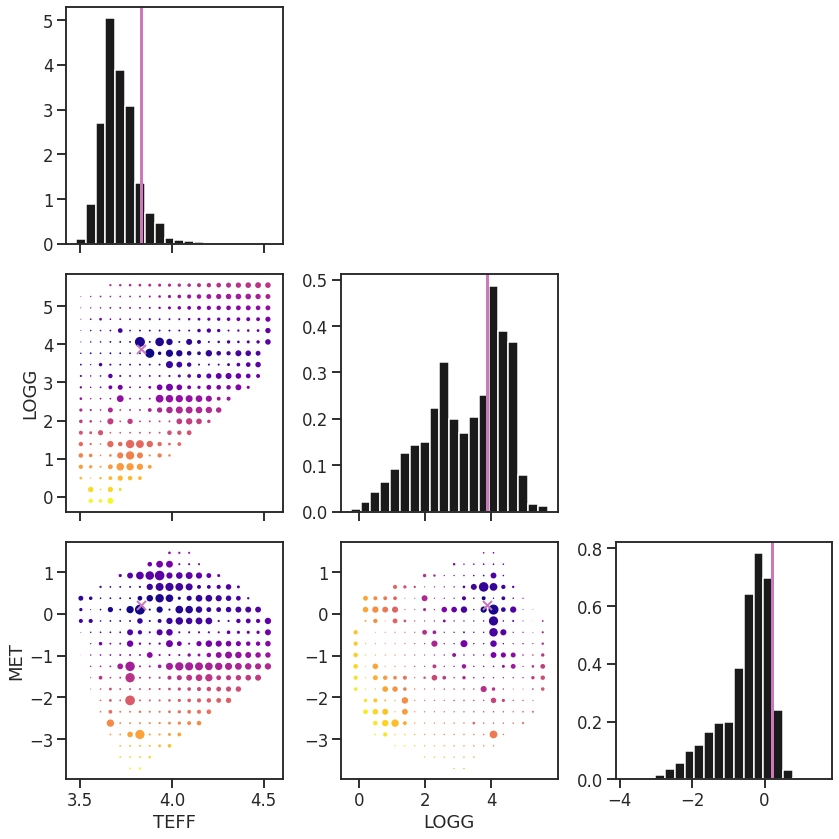

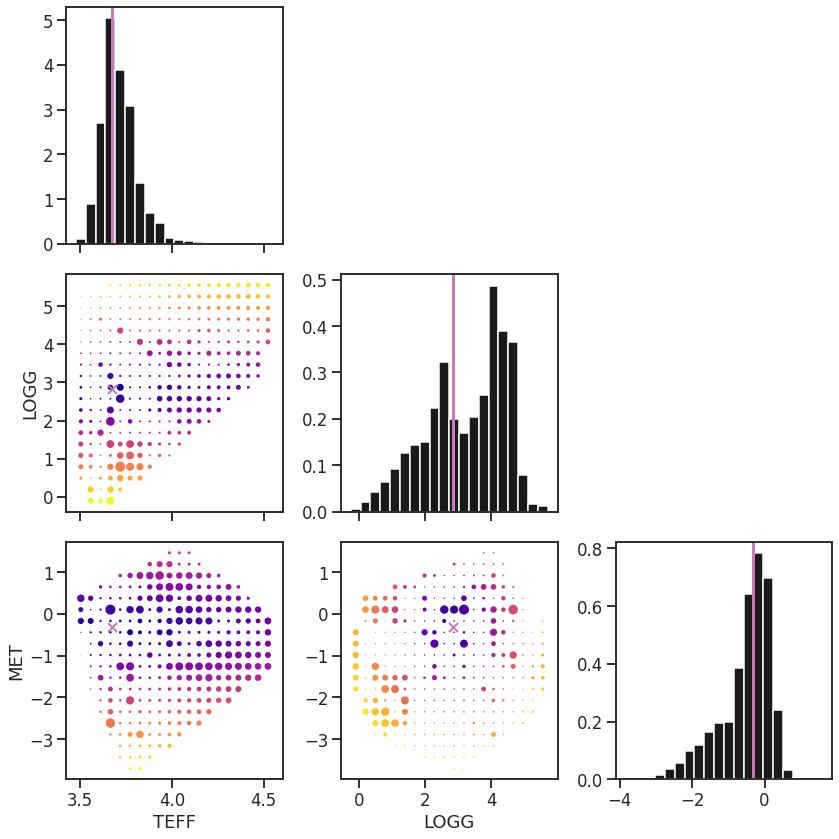

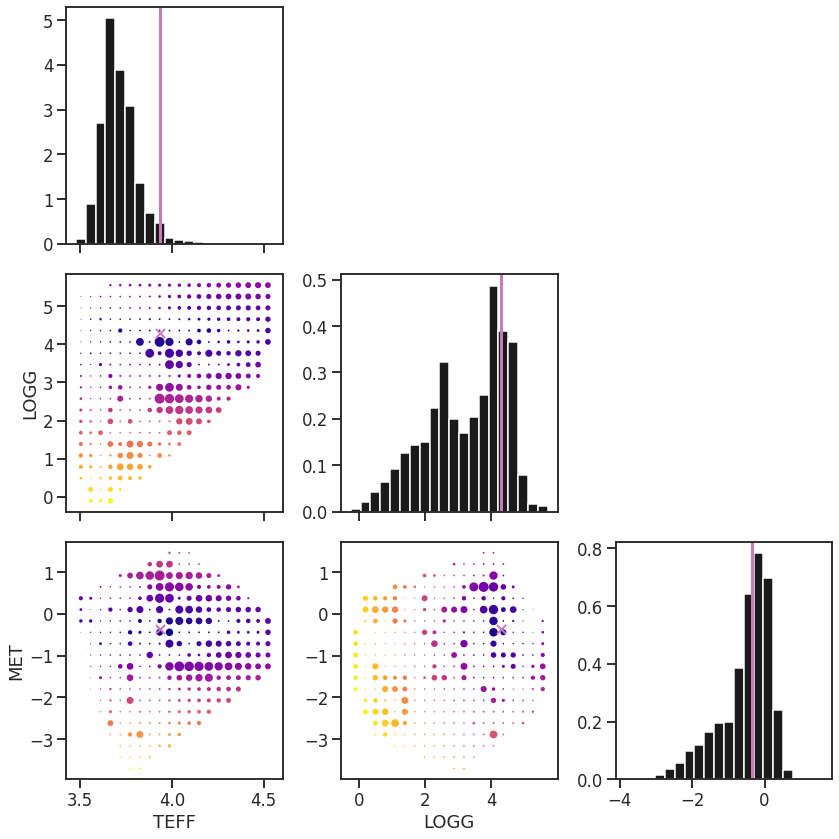

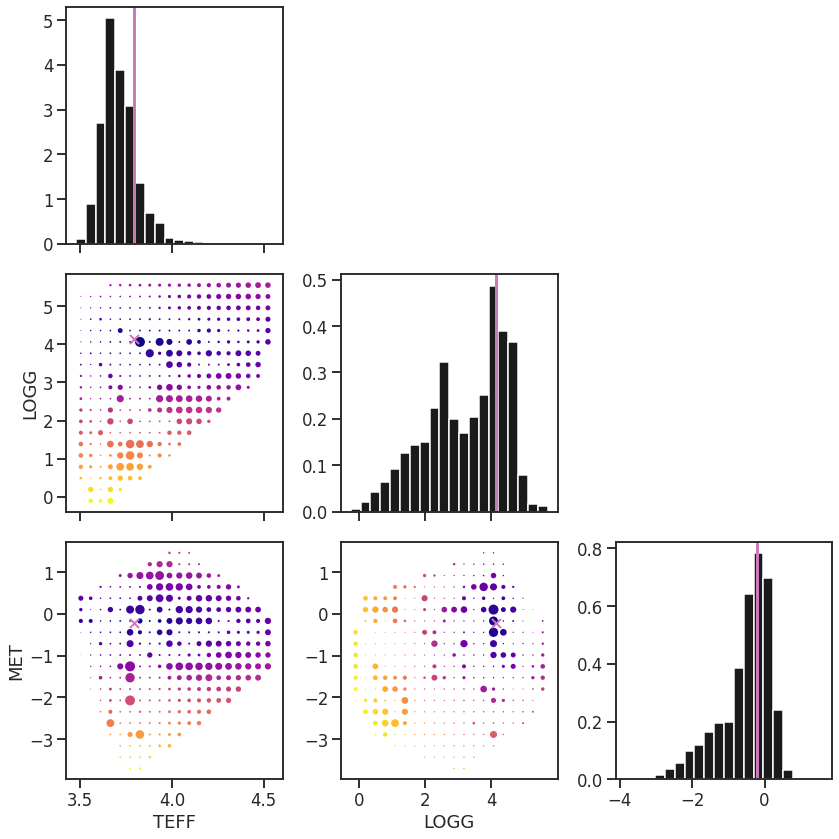

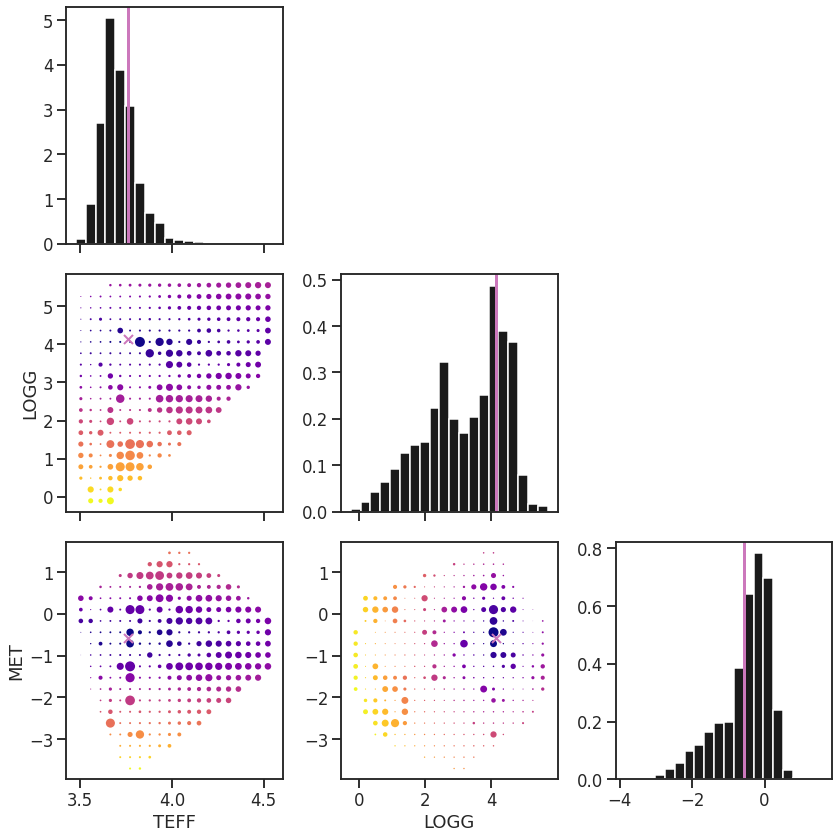

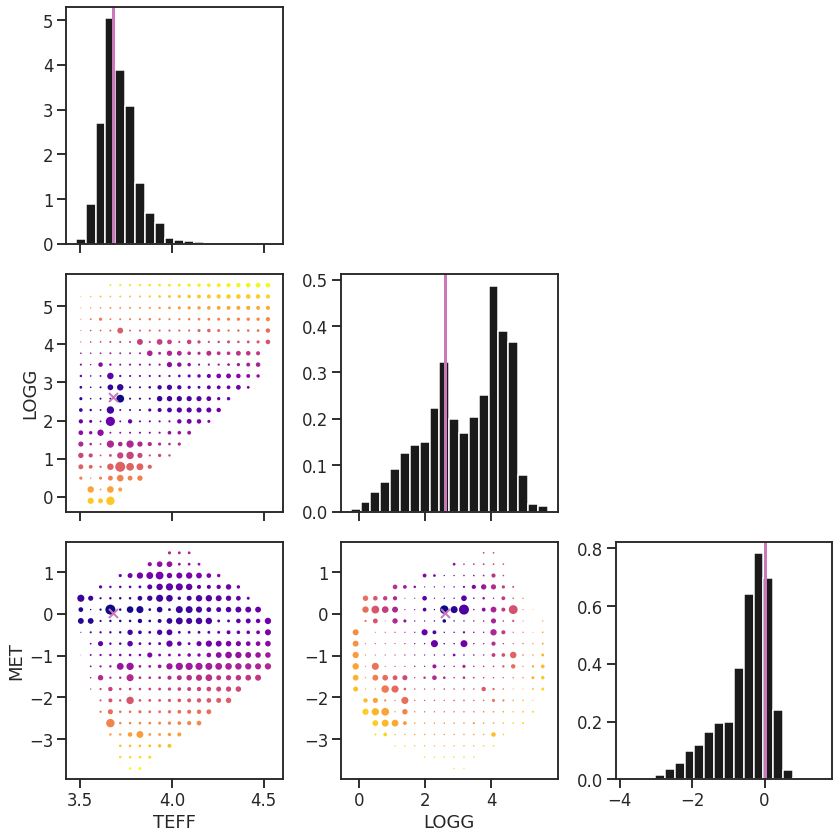

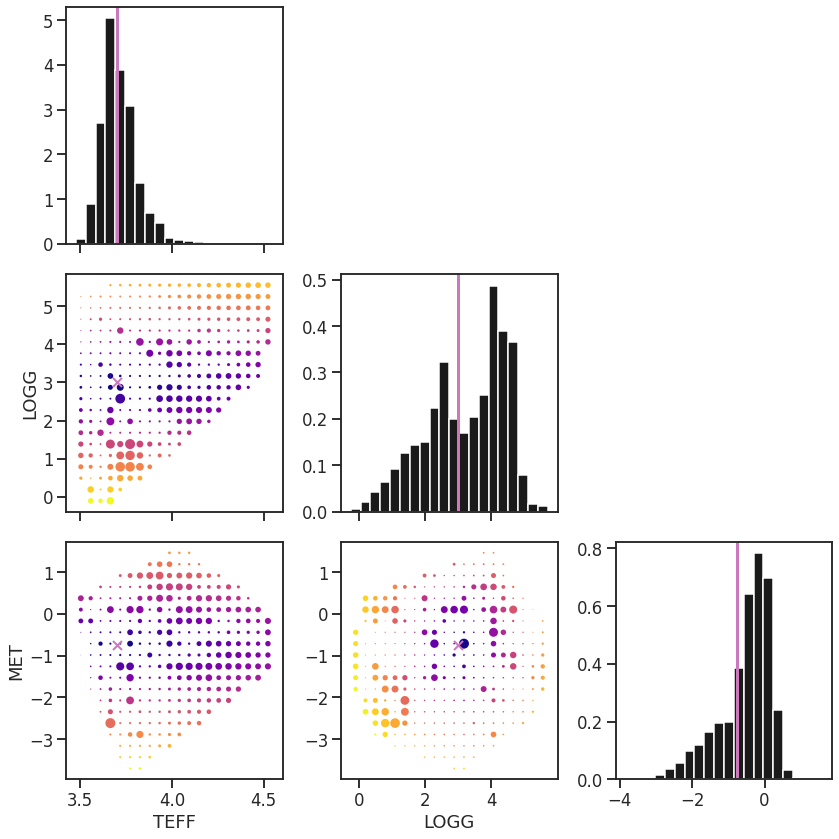

In [5]:
for sed_name in M.index[:10]:
    # z = 1/chi_rd.loc[sed_name].values
    z = 1/(1 + np.log10(1+chi_rd.astype(np.float).loc[sed_name].values))
    # z = 2 * ((1 + chi_rd.loc[sed_name].values)**0.5 - 1)
    # z = np.arctan(chi_rd.loc[sed_name].values)
    true = Y.loc[sed_name]

    fig = triang_plot(Y, Y_COLUMNS, z, true)
    fig.tight_layout()
#     fig.savefig(os.path.join(IMG_PATH, f"auto-fitting-{sed_name}.pdf"))